In [17]:
import os

In [18]:
print(os.getcwd())

/tf/home/sergio/Tesis/COCODataset/pedestrian_dataset_val


In [19]:
root_path = "/tf/home/sergio/Tesis"

In [20]:
import sys
sys.path.append(root_path+"/TinyYOLOv3-Pedestrian-Detection")

from YOLOfunctional import TinyYOLOv3_functional,nms_layer
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
#from tensorflow.python.tools import freeze_graph
#from skimage.io import imread,imshow
#from skimage.transform import resize 
import time
#from tensorflow.compat.v1.image import decode_image
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import os

In [21]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [22]:
def get_iou_matrix_tf(box_arr1, box_arr2):
    #print(box_arr1)
    #print(box_arr2)
    x11, y11, x12, y12 = tf.split(box_arr1, 4, axis=1)
    x21, y21, x22, y22 = tf.split(box_arr2, 4, axis=1)
    xA = tf.maximum(x11, tf.transpose(x21))
    #print(xA)
    yA = tf.maximum(y11, tf.transpose(y21))
    #print(yA)
    xB = tf.minimum(x12, tf.transpose(x22))
    #print(xB)
    yB = tf.minimum(y12, tf.transpose(y22))
    #print(yB)
    interArea = tf.maximum((xB - xA + 1e-9), 0) * tf.maximum((yB - yA + 1e-9), 0)
    #print("interseccion",interArea)
    boxAArea = (x12 - x11 + 1e-9) * (y12 - y11 + 1e-9)
    #print("area gt",boxAArea)
    boxBArea = (x22 - x21 + 1e-9) * (y22 - y21 + 1e-9)
    #print("area pre",boxBArea)
    iou = interArea / (boxAArea + tf.transpose(boxBArea) - interArea)
    #print(iou)
    return tf.cast(iou>=0.5,dtype=tf.int32),iou

In [23]:
def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end

    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [24]:
os.chdir(root_path+"/COCODataset/coco_csvs")
annotations_val_set = pd.read_csv("COCO_annotations_val.csv")
annotations_val_set.drop("Unnamed: 0",axis=1)

,file_name,xmin,ymin,xmax,ymax
0,000000532481.jpg,0.391906,0.394977,0.501453,0.547277
1,000000532481.jpg,0.446172,0.869859,0.465031,0.914953
2,000000458755.jpg,0.107859,0.078646,0.901687,0.986521
3,000000458755.jpg,0.885938,0.002646,1.000000,0.183604
4,000000458755.jpg,0.921906,0.191021,0.999437,0.393250
...,...,...,...,...,...
10999,000000098287.jpg,0.870193,0.408687,0.882000,0.440844
11000,000000098287.jpg,0.419277,0.389062,0.455422,0.418750
11001,000000417779.jpg,0.736297,0.178083,0.765656,0.267104
11002,000000024567.jpg,0.000000,0.000000,0.876958,0.745188


In [25]:
metadata_val_set = pd.read_csv("COCO_metadata_val.csv",index_col=0)

In [26]:
metadata_val_set

,width,height
000000532481.jpg,640,426
000000458755.jpg,640,480
000000385029.jpg,640,480
000000311303.jpg,640,427
000000393226.jpg,640,480
...,...,...
000000229358.jpg,640,423
000000098287.jpg,415,640
000000417779.jpg,640,480
000000024567.jpg,480,640


In [27]:
os.chdir(root_path+"/COCODataset/pedestrian_dataset_val")
validation_images_names = os.listdir()
print(len(validation_images_names))

2693


In [28]:
detections_df = pd.DataFrame(columns=["file_name","xmin","ymin","xmax","ymax","score","TP","FP","cum TP","cum FP","precision","recall"])

In [13]:
#anchors =[[10/416,14/416],[23/416,27/416],[37/416,58/416],[81/416,82/416],[135/416,169/416],[344/416,319/416]]
anchors =[[0.02078,0.049],[0.0426,0.128],[0.08523,0.19356],[0.1506,0.4163],[0.27835,0.58651],[0.5632,0.78614]]

model = TinyYOLOv3_functional(anchor_boxes = anchors,num_classes=0,mode="tl",training=False)
model.training = False
current_directory= '/tf/home/sergio/Tesis/TinyYOLOv3-Pedestrian-Detection/Deployment'
#model.load_weights(current_directory+'/weights_retrain_functional/fine_tuning_part_3_experiment1')
model.load_weights(current_directory+'/weights_fine_tuning_functional/rmsprop_2211_60_70_epochs')
#model.load_weights(root_path+"/training_1/cp.ckpt")

## Evaluación de mis modelos

In [33]:
import numpy as np
def yxyx_to_yxwh(bbox):
    x_min,y_min,x_max,y_max=np.split(bbox,4,axis=0)
    
    width = x_max-x_min
    height = y_max-y_min
    x_center = x_min + (width/2)
    y_center = y_min + (height/2)
    
    out = np.concatenate((x_center,y_center,width,height))
    
    return out

def errors(bbox_pred,bbox_gt):
    
    bbox_pred = yxyx_to_yxwh(bbox_pred)
    bbox_gt = yxyx_to_yxwh(bbox_gt)
    
    xy_error = np.square(bbox_pred[0]-bbox_gt[0]) + np.square(bbox_pred[1]-bbox_gt[1]) 
    wh_error = np.square(bbox_pred[3]-bbox_gt[3]) + np.square(bbox_pred[2]-bbox_gt[2])
    
    return (xy_error,wh_error)

In [34]:
bbox_prueba = np.array([50,30,120,150])

In [35]:
yxyx_to_yxwh(bbox_prueba)

array([ 85.,  90.,  70., 120.])

In [36]:
inicio = time.time()
os.chdir(root_path+"/COCODataset/pedestrian_dataset_val")

detections_df = pd.DataFrame(columns=["file_name","xmin","ymin","xmax","ymax","score","xy_error","wh_error","TP","FP"])
results_eval = []
obj_thresh = 0.5

nms = False

for image in validation_images_names:
    #print(image)
    annotations_images_df = annotations_val_set[annotations_val_set.file_name==image]

    image_height = metadata_val_set.loc[image]["height"]
    image_width = metadata_val_set.loc[image]["width"]
    
    groud_truth_bboxes = annotations_val_set[annotations_val_set.file_name==image].values[:,2:].astype(np.float32)
    groud_truth_bboxes[:,[0,2]] = groud_truth_bboxes[:,[0,2]]#*image_width
    groud_truth_bboxes[:,[1,3]] = groud_truth_bboxes[:,[1,3]]#*image_height
    
    img_raw = tf.image.decode_image(open(image, 'rb').read(), channels=3)
    img = tf.expand_dims(img_raw, 0)
    img = tf.image.resize(img, (416, 416))/255
    
    if not nms:
        outputs = model(img).numpy()[0,:,:];

        predicted_boxes =np.abs(outputs[outputs[:,-1] >= obj_thresh])[:,:4]
        scores = np.abs(outputs[outputs[:,-1] >= obj_thresh])[:,4]
        #print(predicted_boxes)
        predicted_boxes[:,[0,2]] = predicted_boxes[:,[0,2]]#*image_width
        predicted_boxes[:,[1,3]] = predicted_boxes[:,[1,3]]#*image_height
        
    else:
        boxes,scores = model(img);
        #print(indices.numpy())
        #print(boxes.numpy().shape)
        
        predicted_boxes = np.clip(boxes.numpy()[0,:,:],0,1)#[indices.numpy(),:]
        scores = scores.numpy()

        #predicted_boxes = outputs[0].numpy()[0,0:outputs[3][0].numpy(),:]
        #scores = outputs[1].numpy()[0,0:outputs[3][0].numpy()] 
        
        
        predicted_boxes[:,[0,2]] = predicted_boxes[:,[0,2]]#*image_width
        predicted_boxes[:,[1,3]] = predicted_boxes[:,[1,3]]#*image_height
        
    for box,score in zip(predicted_boxes,scores):

        iou_resulted,iou = get_iou_matrix_tf(groud_truth_bboxes, box[tf.newaxis,:])
        
        if np.sum(iou_resulted) >= 1:
            tp = 1
            fp = 0
            which_gt = np.argmax(iou)
            iou_value = np.max(iou)
            #print(iou_value)
            coord_gt = groud_truth_bboxes[which_gt,:]
            
            xy_error,wh_error = errors(box,coord_gt)
            
            groud_truth_bboxes=np.delete(groud_truth_bboxes,which_gt,axis=0)
        #NO hay algún ground truth con el que tenga mas de 0.5 de IoU    
        elif np.sum(iou_resulted) == 0:
            fp = 1
            tp = 0
            
            
            #EL objeto predicho de plano no machea con ninǵún ground truth
            if iou.shape[0]>0  and np.sum(iou)==0:
                iou_value=0
                xy_error=-1
                wh_error=-1    
            #EL objeto predicho hizo match con algún ground truth pero no lo suficiente paara ser un TP    
            elif iou.shape[0]>0  and np.sum(iou)>0:
                
                iou_value = np.max(iou)
                which_gt = np.argmax(iou)
                coord_gt = groud_truth_bboxes[which_gt,:]
                xy_error,wh_error = errors(box,coord_gt)                
                
            # La red detecto un objecto donde ya no hay groudn truth 
            elif iou.shape[0]==0:
                
                iou_value=0
                xy_error=-2
                wh_error=-2     

        predicted_dict = {"file_name":[image],"xmin":[box[0]],"ymin":[box[1]],"xmax":[box[2]],"ymax":[box[3]],"score":[score],
                          "xy_error":[xy_error],"wh_error":[wh_error],"iou":[iou_value],"TP":[tp],"FP":[fp]}
        
        aux = pd.DataFrame(predicted_dict)
        detections_df = pd.concat((detections_df,aux),ignore_index=True)
        #print(aux)        
        
        #print(groud_truth_bboxes)
        #print(iou)

detections_df = detections_df.sort_values(by="score",ascending=False)
cum_tp = np.cumsum(detections_df["TP"].values)
cum_fp = np.cumsum(detections_df["FP"].values)
detections_df.insert(detections_df.shape[1],"cum TP",cum_tp)
detections_df.insert(detections_df.shape[1],"cum FP",cum_fp)
detections_df["Precision"]= (detections_df.loc[:,"cum TP"]/(detections_df.loc[:,"cum TP"] + detections_df.loc[:,"cum FP"])).astype(np.float32)
detections_df["Recall"]= (detections_df.loc[:,"cum TP"]/11004).astype(np.float32)
detections_df["FP"]=detections_df["FP"].astype(np.int32)
detections_df["TP"]=detections_df["TP"].astype(np.int32)
detections_df["xy_error"] = detections_df["xy_error"].astype(np.float32)
detections_df["wh_error"] = detections_df["wh_error"].astype(np.float32)
fin = time.time()
print(fin-inicio)

78.8461000919342


In [37]:
#%timeit boxes,scores = model(img)

In [38]:
detections_df.dtypes

file_name     object
xmin         float64
ymin         float64
xmax         float64
ymax         float64
score        float64
xy_error     float32
wh_error     float32
TP             int32
FP             int32
iou          float64
cum TP        object
cum FP        object
Precision    float32
Recall       float32
dtype: object

In [39]:
detections_df

,file_name,xmin,ymin,xmax,ymax,score,xy_error,wh_error,TP,FP,iou,cum TP,cum FP,Precision,Recall
922,000000057597.jpg,0.829626,0.339142,0.980530,0.662843,0.999997,0.000497,0.000604,1,0,0.771466,1,0,1.000000,0.000091
1830,000000038210.jpg,0.158694,0.411177,0.499624,0.878082,0.999996,0.000249,0.001978,1,0,0.864050,2,0,1.000000,0.000182
1146,000000061418.jpg,0.430107,0.566069,0.580586,0.904937,0.999983,0.000077,0.002749,1,0,0.721045,3,0,1.000000,0.000273
1992,000000507797.jpg,0.164985,0.438399,0.259262,0.876716,0.999977,0.000040,0.000914,1,0,0.757335,4,0,1.000000,0.000364
612,000000442836.jpg,0.061537,0.341584,0.173793,0.777970,0.999972,0.000262,0.000020,1,0,0.786513,5,0,1.000000,0.000454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1937,000000052007.jpg,0.678727,0.391426,0.774220,0.613777,0.500580,0.006092,0.005837,0,1,0.091478,1933,705,0.732752,0.175663
507,000000099182.jpg,0.349813,0.107480,0.756889,1.028210,0.500443,-2.000000,-2.000000,0,1,0.000000,1933,706,0.732474,0.175663
903,000000560911.jpg,0.164277,0.040718,0.822049,0.846708,0.500258,0.003237,0.021514,1,0,0.721174,1934,706,0.732576,0.175754
681,000000129062.jpg,0.769383,0.465036,0.812898,0.579530,0.500119,-1.000000,-1.000000,0,1,0.000000,1934,707,0.732298,0.175754


In [40]:
final_p = detections_df.Precision.iloc[-1]
final_r = detections_df.Recall.iloc[-1]
f1_score = (2*final_p*final_r)/(final_p+final_r)

In [41]:
f1_score

0.28345302308491666

In [42]:
detections_df[detections_df.iou != 0][detections_df.FP==1].loc[:,["score","xy_error","wh_error","iou"]].describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,score,xy_error,wh_error,iou
count,501.000000,501.000000,501.000000,501.000000
mean,0.705338,0.030913,0.147403,0.262292
std,0.141243,0.052445,0.287695,0.161960
min,0.500083,0.000001,0.000001,0.000968
25%,0.583674,0.000399,0.000793,0.111697
50%,0.680928,0.005990,0.013826,0.271152
75%,0.807504,0.035016,0.135267,0.412681
max,0.999621,0.306204,1.701645,0.499354


In [43]:
detections_df[detections_df.iou != 0][detections_df.FP==0].loc[:,["score","xy_error","wh_error","iou"]].describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,score,xy_error,wh_error,iou
count,1934.000000,1.934000e+03,1.934000e+03,1934.000000
mean,0.779772,1.405742e-03,6.320691e-03,0.736204
std,0.158676,3.266584e-03,1.424829e-02,0.108377
min,0.500258,4.829985e-08,4.135209e-07,0.500451
25%,0.639974,8.730775e-05,4.213166e-04,0.655545
50%,0.787263,2.841522e-04,1.465629e-03,0.747937
75%,0.930788,1.081886e-03,5.279157e-03,0.820879
max,0.999997,4.685313e-02,1.970987e-01,0.973794


In [44]:
detections_df[detections_df.iou == 0]

,file_name,xmin,ymin,xmax,ymax,score,xy_error,wh_error,TP,FP,iou,cum TP,cum FP,Precision,Recall
2283,000000480936.jpg,0.158194,0.018710,0.710918,0.986214,0.998275,-2.0,-2.0,0,1,0.0,63,2,0.969231,0.005725
2503,000000477955.jpg,0.364805,0.673235,0.567793,0.966990,0.997134,-2.0,-2.0,0,1,0.0,89,4,0.956989,0.008088
2329,000000001268.jpg,0.777712,0.269990,0.985698,0.984573,0.995354,-1.0,-1.0,0,1,0.0,117,6,0.951219,0.010632
108,000000518326.jpg,0.514517,0.027145,0.672738,0.362115,0.995150,-1.0,-1.0,0,1,0.0,119,7,0.944444,0.010814
1727,000000009483.jpg,0.058785,0.141786,0.287849,0.990032,0.992640,-2.0,-2.0,0,1,0.0,145,10,0.935484,0.013177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,000000509403.jpg,0.791147,0.541434,0.933231,0.830532,0.503659,-1.0,-1.0,0,1,0.0,1917,698,0.733078,0.174209
338,000000289938.jpg,0.086038,0.454773,0.110777,0.522193,0.502940,-1.0,-1.0,0,1,0.0,1919,700,0.732722,0.174391
506,000000099182.jpg,0.271748,0.013651,0.735266,0.957168,0.501424,-2.0,-2.0,0,1,0.0,1930,702,0.733283,0.175391
507,000000099182.jpg,0.349813,0.107480,0.756889,1.028210,0.500443,-2.0,-2.0,0,1,0.0,1933,706,0.732474,0.175663


In [45]:
#0.533149	0.157852

In [46]:
print("Objetos detectados que no correspondieron a algún GT",len(detections_df[detections_df.xy_error == -1]))
print("Objetos detectados donde ya no habían GT",len(detections_df[detections_df.xy_error == -2]))
print("Total:",len(detections_df[detections_df.xy_error == -1])+len(detections_df[detections_df.xy_error == -2]) )

Objetos detectados que no correspondieron a algún GT 139
Objetos detectados donde ya no habían GT 68
Total: 207


Tomamos en cuenta solamente los bouding box que si tienen algun IoU con un ground truth

In [47]:
detections_df[detections_df.iou != 0].loc[:,["score","xy_error","wh_error","iou"]].describe()

,score,xy_error,wh_error,iou
count,2435.000000,2.435000e+03,2.435000e+03,2435.000000
mean,0.764457,7.476839e-03,3.534837e-02,0.638697
std,0.158113,2.675506e-02,1.428911e-01,0.226790
min,0.500083,4.829985e-08,4.135209e-07,0.000968
25%,0.621681,1.075612e-04,4.554667e-04,0.549588
50%,0.762846,3.987205e-04,1.829070e-03,0.705865
75%,0.914033,2.169648e-03,9.067889e-03,0.800309
max,0.999997,3.062036e-01,1.701645e+00,0.973794


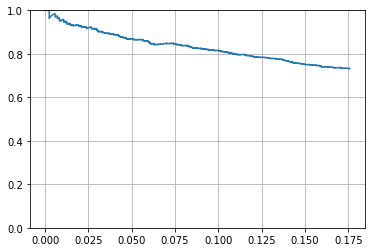

In [48]:
plt.plot(detections_df["Recall"],detections_df["Precision"])
plt.ylim([0,1])
plt.grid()

In [49]:
compute_ap(detections_df["Recall"].values, detections_df["Precision"].values)

0.14655620033482344

In [31]:
detections_df

,file_name,xmin,ymin,xmax,ymax,score,xy_error,wh_error,TP,FP,iou,cum TP,cum FP,Precision,Recall
1723,000000038210.jpg,0.148083,0.408373,0.504878,0.861010,0.981331,0.000031,0.001860,1,0,0.851654,1,0,1.000000,0.000091
1056,000000458325.jpg,0.460651,0.348647,0.559218,0.823676,0.971730,0.000207,0.000329,1,0,0.791261,2,0,1.000000,0.000182
2094,000000323799.jpg,0.582490,0.232375,0.693781,0.760238,0.968657,0.000041,0.001322,1,0,0.882794,3,0,1.000000,0.000273
1721,000000507037.jpg,0.458150,0.503081,0.542829,0.980606,0.964101,0.000634,0.001008,1,0,0.631143,4,0,1.000000,0.000364
2353,000000309467.jpg,0.708894,0.253995,0.802687,0.757549,0.963906,0.000073,0.000865,1,0,0.790706,5,0,1.000000,0.000454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2287,000000138639.jpg,0.886028,0.685032,0.900613,0.727506,0.500658,0.020656,0.084548,0,1,0.014326,1895,588,0.763190,0.172210
1470,000000430073.jpg,0.904822,0.424395,0.987092,0.674216,0.500609,0.001163,0.006682,1,0,0.501448,1896,588,0.763285,0.172301
1814,000000361586.jpg,0.290016,0.500594,0.407162,0.981287,0.500573,0.055213,0.561830,0,1,0.105142,1896,589,0.762978,0.172301
2126,000000396200.jpg,0.467656,0.210527,0.626154,0.679197,0.500315,0.000048,0.002797,1,0,0.732010,1897,589,0.763073,0.172392


In [93]:
#os.chdir("/tf/home/sergio/")
#detections_df.to_csv("detections_df_best_result_2_anchors")

In [69]:
groud_truth_bboxes

array([], shape=(0, 4), dtype=float32)

In [70]:
groud_truth_bboxes = annotations_val_set[annotations_val_set.file_name==image].values[:,2:].astype(np.float32)

In [71]:
groud_truth_bboxes

array([[0.63820314, 0.01355972, 0.9965938 , 0.98519903]], dtype=float32)

In [33]:
import cv2
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)

def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2):
    
    #x_center, y_center, width, height = bbox#*416
    x_min,y_min,x_max,y_max=bbox
    #x_min = int(x_center-(width//2))
    #y_min = int(y_center-(height//2))
    #x_max = int(x_center+(width//2))
    #y_max = int(y_center+(height//2))
    
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    #class_name = class_idx_to_name[class_id]
    #((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    #cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    #cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img

def visualize(image,bboxes):
    img = image.copy()
    for idx, bbox in enumerate(bboxes):
        img = visualize_bbox(img, bbox)
    plt.imshow(img)

In [34]:
predicted_boxes

array([[373.81348 ,  25.896667, 615.27    , 435.19962 ]], dtype=float32)

In [20]:
annotations_val_set[annotations_val_set.file_name == image]

,Unnamed: 0,file_name,xmin,ymin,xmax,ymax
9527,9527,000000170955.jpg,0.638203,0.01356,0.996594,0.985199


In [21]:
detections_df[detections_df.file_name == "000000397354.jpg"]
predicted_boxes = (detections_df[detections_df.file_name == "000000397354.jpg"].iloc[:,1:5]).values
print(predicted_boxes)

[[315.67272949 140.80905151 377.53302002 305.77975464]
 [111.07653809 186.75032043 191.20257568 334.90444946]
 [477.97073364 223.60594177 618.76519775 448.35531616]
 [202.08599854 153.03851318 297.49255371 300.46600342]]


In [22]:
img_raw = tf.image.decode_image(open("000000397354.jpg", 'rb').read(), channels=3)
img = tf.expand_dims(img_raw, 0)
img = tf.image.resize(img, (416, 416))/255
    
visualize(resize(img.numpy()[0,:,:,:],(image_height,image_width)),predicted_boxes)

TypeError: Argument given by name ('color') and position (3)

In [ ]:
print(np.mean(detections_df["Precision"]))

## Evaluación del modelo original YOLO

In [29]:
anchors =[[10/416,14/416],[23/416,27/416],[37/416,58/416],[81/416,82/416],[135/416,169/416],[344/416,319/416]]
#anchors =tf.constant(np.array([[0,0,0.026,0.062],[0,0,0.067,0.183],[0,0,0.128,0.323],[0,0,0.343,0.650]]),dtype=tf.float32)
model = TinyYOLOv3(80,anchor_boxes=anchors,train=False,mode = "finetuning",obj_threshold=0.5)
model.build(batch_input_shape=(None,416,416,3))
model.load_weights_darknet(root_path+"/TinyYOLOv3-Pedestrian-Detection/yolov3-tiny.weights")
#model.load_weights('/home/sergio/Documents/weights_saved/pesos_1241_50_epoch_nadam_0dot0001_msle_exp_mse')

NameError: name 'TinyYOLOv3' is not defined

In [15]:
inicio = time.time()
os.chdir(root_path+"/COCODataset/pedestrian_dataset_val")

detections_df = pd.DataFrame(columns=["file_name","xmin","ymin","xmax","ymax","score","TP","FP"])
results_eval = []
obj_thresh = 0.3

for image in validation_images_names:
    #print(image)
    annotations_images_df = annotations_val_set[annotations_val_set.file_name==image]

    image_height = metadata_val_set.loc[image]["height"]
    image_width = metadata_val_set.loc[image]["width"]
    
    groud_truth_bboxes = annotations_val_set[annotations_val_set.file_name==image].values[:,2:].astype(np.float32)
    groud_truth_bboxes[:,[0,2]] = groud_truth_bboxes[:,[0,2]]#*image_width
    groud_truth_bboxes[:,[1,3]] = groud_truth_bboxes[:,[1,3]]#*image_height
    
    img_raw = tf.image.decode_image(open(image, 'rb').read(), channels=3)
    img = tf.expand_dims(img_raw, 0)
    img = tf.image.resize(img, (416, 416))/255
    
    outputs = model(img);
    

    real_outputs = outputs[2].numpy()[0,0:outputs[3][0].numpy()]
    person_index = np.where(real_outputs ==0)
    #print(person_index)
    #person_outputs 
    predicted_boxes = outputs[0].numpy()[0,0:outputs[3][0].numpy(),:][person_index,:][0,:,:]
    scores = outputs[1].numpy()[0,0:outputs[3][0].numpy()][person_index]
        
    #print(predicted_boxes.shape)
    #print(scores.shape)
    
    predicted_boxes[:,[0,2]] = predicted_boxes[:,[0,2]]#*image_width
    predicted_boxes[:,[1,3]] = predicted_boxes[:,[1,3]]#*image_height

    for box,score in zip(predicted_boxes,scores):

        iou_resulted,iou = get_iou_matrix_tf(groud_truth_bboxes, box[tf.newaxis,:])
        
        if np.sum(iou_resulted) >= 1:
            tp = 1
            fp = 0
            which_gt = np.argmax(iou)
            iou_value = np.max(iou)
            #print(iou_value)
            coord_gt = groud_truth_bboxes[which_gt,:]
            
            xy_error,wh_error = errors(box,coord_gt)
            
            groud_truth_bboxes=np.delete(groud_truth_bboxes,which_gt,axis=0)
        #NO hay algún ground truth con el que tenga mas de 0.5 de IoU    
        elif np.sum(iou_resulted) == 0:
            fp = 1
            tp = 0
            
            
            #EL objeto predicho de plano no machea con ninǵún ground truth
            if iou.shape[0]>0  and np.sum(iou)==0:
                iou_value=0
                xy_error=-1
                wh_error=-1    
            #EL objeto predicho hizo match con algún ground truth pero no lo suficiente paara ser un TP    
            elif iou.shape[0]>0  and np.sum(iou)>0:
                
                iou_value = np.max(iou)
                which_gt = np.argmax(iou)
                coord_gt = groud_truth_bboxes[which_gt,:]
                xy_error,wh_error = errors(box,coord_gt)                
                
            # La red detecto un objecto donde ya no hay groudn truth 
            elif iou.shape[0]==0:
                
                iou_value=0
                xy_error=-2
                wh_error=-2     

        predicted_dict = {"file_name":[image],"xmin":[box[0]],"ymin":[box[1]],"xmax":[box[2]],"ymax":[box[3]],"score":[score],
                          "xy_error":[xy_error],"wh_error":[wh_error],"iou":[iou_value],"TP":[tp],"FP":[fp]}
        aux = pd.DataFrame(predicted_dict)
        detections_df = pd.concat((detections_df,aux),ignore_index=True)
        #print(aux)        
        
        #print(groud_truth_bboxes)
        #print(iou)
    '''
    x_min,y_min,x_max,y_max =np.split(predicted_boxes,4,axis=1)
    x_min,x_max = x_min*image_width,x_max*image_width
    y_min,y_max = y_min*image_height,y_max*image_height
    
    width = x_max-x_min
    height = y_max-y_min
    x_global =x_min + tf.math.divide(x_max - x_min,2)
    y_global =y_min + tf.math.divide(y_max - y_min,2)    
    '''
detections_df = detections_df.sort_values(by="score",ascending=False)
cum_tp = np.cumsum(detections_df["TP"].values)
cum_fp = np.cumsum(detections_df["FP"].values)
detections_df.insert(detections_df.shape[1],"cum TP",cum_tp)
detections_df.insert(detections_df.shape[1],"cum FP",cum_fp)
detections_df["Precision"]= detections_df.loc[:,"cum TP"]/(detections_df.loc[:,"cum TP"] + detections_df.loc[:,"cum FP"])
detections_df["Recall"]= detections_df.loc[:,"cum TP"]/11004

fin = time.time()
print(fin-inicio)

InvalidArgumentError: slice index 2 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

In [16]:
detections_df

,file_name,xmin,ymin,xmax,ymax,score,TP,FP


In [34]:
os.chdir("/tf/home/sergio/")
detections_df.to_csv("detections_df_original")

In [35]:
detections_df[detections_df.iou != 0].loc[:,["score","xy_error","wh_error","iou"]].describe()

,score,xy_error,wh_error,iou
count,3095.000000,3.095000e+03,3.095000e+03,3095.000000
mean,0.731165,3.493789e-03,2.884628e-02,0.553295
std,0.147491,1.971305e-02,1.384266e-01,0.278347
min,0.500079,8.790930e-08,7.891799e-07,0.001144
25%,0.599684,6.722751e-05,1.284006e-03,0.282306
50%,0.718884,2.116786e-04,4.574302e-03,0.655873
75%,0.862270,7.591554e-04,1.230912e-02,0.809418
max,0.999887,3.399086e-01,1.644850e+00,0.969979


In [36]:
detections_df[detections_df.iou == 0]

,file_name,xmin,ymin,xmax,ymax,score,TP,FP,xy_error,wh_error,iou,cum TP,cum FP,Precision,Recall
1738,000000188465.jpg,0.407143,0.591740,0.478071,0.778925,0.993321,0,1,-1.0,-1.0,0.0,19,1,0.95,0.00172664
2124,000000414170.jpg,0.581575,0.471272,0.668803,0.697526,0.990044,0,1,-1.0,-1.0,0.0,28,3,0.903226,0.00254453
2295,000000516318.jpg,0.621593,0.505404,0.735774,0.668789,0.985258,0,1,-2.0,-2.0,0.0,51,5,0.910714,0.00463468
1657,000000230819.jpg,0.331303,0.383653,0.407461,0.607156,0.976861,0,1,-2.0,-2.0,0.0,98,18,0.844828,0.00890585
2126,000000414170.jpg,0.352634,0.461123,0.423347,0.599882,0.970667,0,1,-1.0,-1.0,0.0,138,27,0.836364,0.0125409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,000000071877.jpg,0.329697,0.058859,0.805247,0.441032,0.504287,0,1,-2.0,-2.0,0.0,1729,1506,0.534467,0.157125
1540,000000378244.jpg,0.384560,0.452061,0.509264,0.581538,0.503933,0,1,-2.0,-2.0,0.0,1729,1509,0.533972,0.157125
1011,000000015956.jpg,0.701783,0.398164,0.736017,0.485610,0.502924,0,1,-1.0,-1.0,0.0,1733,1511,0.534217,0.157488
1101,000000117197.jpg,0.605410,0.249539,0.820185,0.746029,0.502919,0,1,-2.0,-2.0,0.0,1733,1512,0.534052,0.157488


In [37]:
final_p = detections_df.Precision.iloc[-1]
final_r = detections_df.Recall.iloc[-1]
f1_score = (2*final_p*final_r)/(final_p+final_r)

In [38]:
f1_score

0.24429191763552321

In [39]:
detections_df[detections_df.iou != 0][detections_df.FP==1].loc[:,["score","xy_error","wh_error","iou"]].describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,score,xy_error,wh_error,iou
count,1351.000000,1.351000e+03,1351.000000,1351.000000
mean,0.689019,6.781075e-03,0.059832,0.258667
std,0.133750,2.942135e-02,0.205173,0.106216
min,0.500079,8.790930e-08,0.000039,0.001144
25%,0.576978,4.096714e-05,0.005470,0.206485
50%,0.665204,1.253977e-04,0.011268,0.265487
75%,0.790697,4.945673e-04,0.020823,0.325957
max,0.993061,3.399086e-01,1.644850,0.498351


In [40]:
print("Objetos detectados que no correspondieron a algún GT",len(detections_df[detections_df.xy_error == -1]))
print("Objetos detectados donde ya no habían GT",len(detections_df[detections_df.xy_error == -2]))
print("Total:",len(detections_df[detections_df.xy_error == -1])+len(detections_df[detections_df.xy_error == -2]) )

Objetos detectados que no correspondieron a algún GT 120
Objetos detectados donde ya no habían GT 59
Total: 179


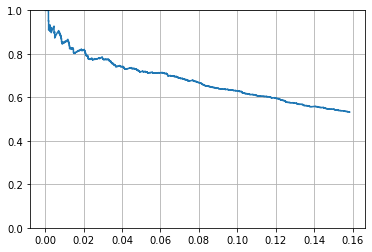

In [41]:
plt.plot(detections_df["Recall"],detections_df["Precision"])
plt.ylim([0,1])
plt.grid()

In [42]:
compute_ap(detections_df["Recall"].values, detections_df["Precision"].values)

0.10801317600914442